##### <b>Step-1: Importing Libraries</b>

In [ ]:
import os                               
import cv2
import time                              
import numpy as np   
import tensorflow as tf 
from PIL import Image
import numpy as np
from skimage import transform
from google.colab import drive 
from keras import backend as K           
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from keras.models import load_model
from keras.preprocessing import image  
from keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

##### <b>Step-2: Mounting Drive</b>

In [ ]:
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


##### <b>Step-3: Setting path for Testing, Training and validation directories</b>

In [ ]:
base_dir = '/content/drive/MyDrive/COVID-19 Deep Learning'
train_dir = '/content/drive/MyDrive/COVID-19 Deep Learning/Train'
validations_dir = '/content/drive/MyDrive/COVID-19 Deep Learning/Validation'
test_dir = '/content/drive/MyDrive/COVID-19 Deep Learning/Test'

##### <b>Step-4: Setting path for classes</b>

In [ ]:
train_covid_dir = '/content/drive/MyDrive/COVID-19 Deep Learning/Train/COVID-19'
train_normal_dir = '/content/drive/MyDrive/COVID-19 Deep Learning/Train/NORMAL'
train_viralpn_dir = '/content/drive/MyDrive/COVID-19 Deep Learning/Train/Viral Pneumonia'

validation_covid_dir = '/content/drive/MyDrive/COVID-19 Deep Learning/Validation/COVID-19'
validation_normal_dir = '/content/drive/MyDrive/COVID-19 Deep Learning/Validation/NORMAL'
validation_viralpn_dir = '/content/drive/MyDrive/COVID-19 Deep Learning/Validation/Viral Pneumonia'

test_covid_dir = '/content/drive/MyDrive/COVID-19 Deep Learning/Test/COVID-19'
test_normal_dir = '/content/drive/MyDrive/COVID-19 Deep Learning/Test/NORMAL'
test_viralpn_dir = '/content/drive/MyDrive/COVID-19 Deep Learning/Test/Viral Pneumonia'

In [ ]:
num_covid_train = len(os.listdir(train_covid_dir))
num_normal_train = len(os.listdir(train_normal_dir))
num_viralpn_train = len(os.listdir(train_viralpn_dir))

num_covid_validaition = len(os.listdir(validation_covid_dir))
num_normal_validation= len(os.listdir(validation_normal_dir))
num_viralpn_validation= len(os.listdir(validation_viralpn_dir))

num_covid_test = len(os.listdir(test_covid_dir))
num_normal_test= len(os.listdir(test_normal_dir))
num_viralpn_test= len(os.listdir(test_viralpn_dir))

##### <b>Step-5: Printing Total Images of each class</b>

In [ ]:
print("Total Training COVID Images",num_covid_train)
print("Total Training NORMAL Images",num_normal_train)
print("Total Training VIRALPN Images",num_viralpn_train)

print("--")
print("Total validation COVID Images",num_covid_validaition)
print("Total validation NORMAL Images",num_normal_validation)
print("Total validation VIRALPN Images",num_viralpn_validation)

print("--")
print("Total Test COVID Images", num_covid_test)
print("Total Test NORMAL Images",num_normal_test)
print("Total Test VIRALPN Images",num_viralpn_test)

Total Training COVID Images 450
Total Training NORMAL Images 725
Total Training VIRALPN Images 201
--
Total validation COVID Images 175
Total validation NORMAL Images 250
Total validation VIRALPN Images 83
--
Total Test COVID Images 175
Total Test NORMAL Images 250
Total Test VIRALPN Images 83


##### <b>Step-6: Printing Total training, testing and validation images</b>

In [ ]:
total_train = num_covid_train+num_normal_train+num_viralpn_train
total_validation = num_covid_validaition+num_normal_validation+num_viralpn_validation
total_test = num_covid_test+num_normal_test+num_viralpn_test
print("Total Training Images",total_train)
print("--")
print("Total Validation Images",total_validation)
print("--")
print("Total Testing Images",total_test)

Total Training Images 1376
--
Total Validation Images 508
--
Total Testing Images 508


##### <b>Step-7: Defining Image shape and batch size for Convolutional neural networks</b>

In [ ]:
IMG_SHAPE  = 150 
batch_size = 50

#####<b>Step-8: Function for visualization of images</b>

In [ ]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

#####<b>Step-9:Applying Data Augmentation on training data</b>

In [ ]:
image_gen_train = ImageDataGenerator(rescale = 1./255,rotation_range = 40,width_shift_range=0.2,height_shift_range=0.2,shear_range = 0.2,
                                     zoom_range = 0.2,horizontal_flip = True,fill_mode = 'nearest')
train_data_gen = image_gen_train.flow_from_directory(batch_size = batch_size,
                                                     directory = train_dir,
                                                     shuffle= True,
                                                     target_size = (IMG_SHAPE,IMG_SHAPE),
                                                    class_mode  = "categorical")

Found 1376 images belonging to 3 classes.


##### <b>Step-10: showing augmented images</b>

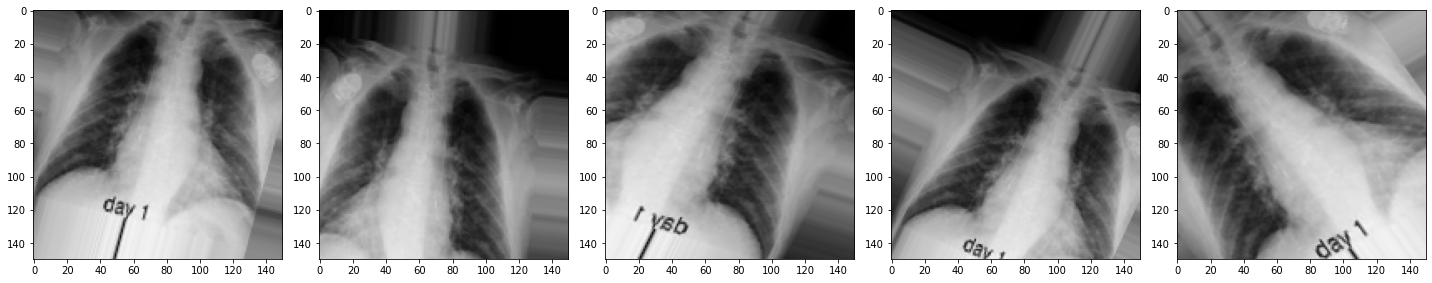

In [ ]:
augmented_images = [train_data_gen[0][0][0] for i in range(20)]
plotImages(augmented_images)

##### <b>Step-11: Preprocessing of validation and testing data</b>

In [ ]:
image_generator_validation = ImageDataGenerator(rescale=1./255)

val_data_gen = image_generator_validation.flow_from_directory(batch_size=50,
                                                 directory=validations_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='categorical')

image_gen_test = ImageDataGenerator(rescale=1./255)

test_data_gen = image_gen_test.flow_from_directory(batch_size=50,
                                                 directory=test_dir,
                                                 target_size=(IMG_SHAPE, IMG_SHAPE),
                                                 class_mode='categorical')

Found 508 images belonging to 3 classes.
Found 508 images belonging to 3 classes.


##### <b>Step-12: building Convolutional Neural Networks</b>

In [ ]:
classifier = tf.keras.Sequential([
        tf.keras.layers.Conv2D(16,(3,3),activation='relu',input_shape=(IMG_SHAPE, IMG_SHAPE, 3)),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(32,(3,3),activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Conv2D(64,(3,3),activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),
        
        tf.keras.layers.Conv2D(128,(3,3),activation='relu'),
        tf.keras.layers.MaxPooling2D(2,2),

        tf.keras.layers.Dropout(0.32),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024,activation= 'relu'),
        tf.keras.layers.Dense(3, activation = "softmax")  
])

##### <b>Step-13: Compiling Convolutional neural networks</b>

In [ ]:
#classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy',tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
classifier.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

#####<b>Step-14: Printing Model Parameters</b>

In [ ]:
classifier.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_61 (Conv2D)           (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d_61 (MaxPooling (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_62 (MaxPooling (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_63 (MaxPooling (None, 17, 17, 64)        0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 15, 15, 128)     

#####<b>Step-15: Training the Convolutional Neural Networks</b>

In [ ]:
history = classifier.fit(train_data_gen,steps_per_epoch=28,epochs = 50,validation_data=val_data_gen,validation_steps=11,verbose = 1)

Epoch 1/50
28/28 [==============================] - 58s 2s/step - loss: 1.1404 - accuracy: 0.4868 - val_loss: 0.7687 - val_accuracy: 0.7087
Epoch 2/50
28/28 [==============================] - 56s 2s/step - loss: 0.7522 - accuracy: 0.7057 - val_loss: 0.7019 - val_accuracy: 0.7835
Epoch 3/50
28/28 [==============================] - 57s 2s/step - loss: 0.7176 - accuracy: 0.7146 - val_loss: 0.5189 - val_accuracy: 0.7736
Epoch 4/50
28/28 [==============================] - 56s 2s/step - loss: 0.6048 - accuracy: 0.7634 - val_loss: 0.4107 - val_accuracy: 0.8110
Epoch 5/50
28/28 [==============================] - 57s 2s/step - loss: 0.5111 - accuracy: 0.8011 - val_loss: 0.5504 - val_accuracy: 0.7677
Epoch 6/50
28/28 [==============================] - 57s 2s/step - loss: 0.4963 - accuracy: 0.8155 - val_loss: 0.3198 - val_accuracy: 0.8976
Epoch 7/50
28/28 [==============================] - 57s 2s/step - loss: 0.4720 - accuracy: 0.8229 - val_loss: 0.3130 - val_accuracy: 0.8484
Epoch 8/50
28/28 [==

#####<b>Step-16:Checking keys of history variable</b>

In [ ]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


#####<b>Step-17:Visualizing the training and validation using accuracy and loss </b>

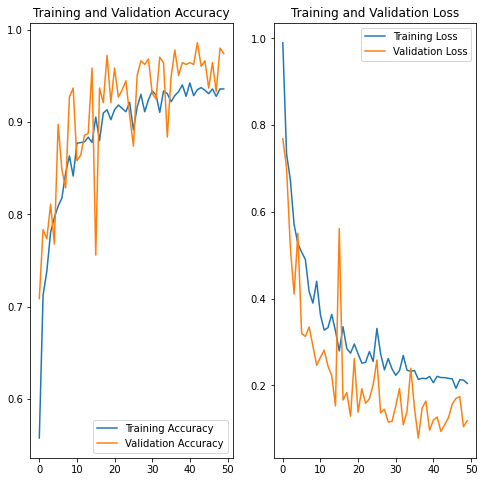

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#####<b>Step-18:Visualizing the training and validation using accuracy and loss in single graph </b>

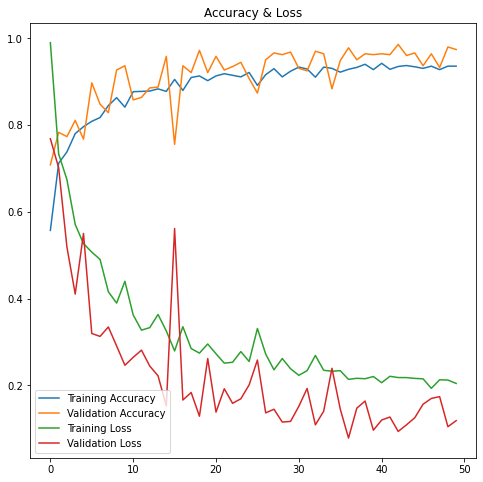

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(50)

plt.figure(figsize=(8, 8))
plt.subplot(1, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Accuracy & Loss')
plt.show()

#####<b>Step-19:Saving model in json and h5 format</b>

In [ ]:
model_json = classifier.to_json()
with open("/content/drive/MyDrive/COVID-19 Deep Learning/COVID_19_Classifier.json", "w") as json_file:
    json_file.write(model_json)
classifier.save('/content/drive/MyDrive/COVID-19 Deep Learning/COVID_19_Classifier.h5')

##### <b>Step-20: Testing Model on test data</b>

In [ ]:
results = classifier.evaluate(test_data_gen,batch_size=50)
print("test_loss, test accuracy",results)

11/11 [==============================] - 115s 11s/step - loss: 0.3332 - accuracy: 0.8642
test_loss, test accuracy [0.333220899105072, 0.8641732335090637]


#####<b>Step-21:visualizing results with confidence</b>

The below image is  NORMAL  with  0.98  confidence


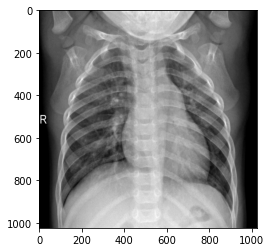

In [ ]:
image_1 = cv2.imread('/content/drive/MyDrive/COVID-19 Deep Learning/Test/NORMAL/NORMAL (1095).png')
image = cv2.resize(image_1, (150, 150))
image = image.astype("float")/255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
predict = classifier.predict(image)
classes=np.argmax(predict,axis=1)
if classes==0:
  res = "COVID-19"
elif classes==1:
  res = "NORMAL"
elif classes==2:
  res = "VIRAL PNEUMONIA"
confidence = str(round(max(predict[0]), 2))
plt.imshow(image_1)
print("The below image is ",res," with ",confidence," confidence")

###### <b>Step-22: buliding a VGG-16 Model</b>

In [ ]:
pre_trained_model = tf.keras.applications.VGG16(input_shape=(224, 224, 3), include_top=False, weights="imagenet")
for layer in pre_trained_model.layers:
    print(layer.name)
    layer.trainable = False
    
print(len(pre_trained_model.layers))
last_layer = pre_trained_model.get_layer('block5_pool')
print('last layer output shape:', last_layer.output_shape)
last_output = last_layer.output

x = tf.keras.layers.GlobalMaxPooling2D()(last_output)
x = tf.keras.layers.Dense(512, activation='relu')(x)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(3, activation='softmax')(x)

58892288/58889256 [==============================] - 0s 0us/step
input_1
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
19
last layer output shape: (None, 7, 7, 512)


#####<b>Step-24:Compiling VGG-16 Model</b>

In [ ]:
model = tf.keras.Model(pre_trained_model.input, x)
optimizer = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['accuracy'])

#####<b>Step-25:Printing Summary of VGG-16 Model</b>

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

#####<b>Step-26:Training VGG-16 Model without Fine Tuning</b>

In [ ]:
epochs = 3
model_history = model.fit(train_data_gen,epochs = epochs, validation_data = val_data_gen,verbose = 1, steps_per_epoch=28, validation_steps=11)

Epoch 1/3
28/28 [==============================] - 452s 16s/step - loss: 1.1085 - accuracy: 0.5046 - val_loss: 0.7659 - val_accuracy: 0.7087
Epoch 2/3
28/28 [==============================] - 288s 10s/step - loss: 0.8553 - accuracy: 0.6539 - val_loss: 0.6214 - val_accuracy: 0.7579
Epoch 3/3
28/28 [==============================] - 288s 10s/step - loss: 0.6938 - accuracy: 0.7459 - val_loss: 0.5299 - val_accuracy: 0.7835


######<b>Step-28:Training VGG-16 Model with Fine Tuning</b>

In [ ]:
for layer in model.layers[:15]:
    layer.trainable = False

for layer in model.layers[15:]:
    layer.trainable = True

##### <b>Step-29:Compiling VGG-16 Model</b>

In [ ]:
optimizer = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(loss='categorical_crossentropy',optimizer=optimizer,metrics=['acc'])

#####<b>Step-30:Printing VGG-16 Model Summary</b>

In [ ]:
model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0  

##### <b>Step-31:setting the last convolutional block to trainable, we are now retraining for half of the hyperparameters</b>

In [ ]:
learning_rate_reduction = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', patience=3, verbose=1, factor=0.5, 
                                            min_lr=0.000001, cooldown=3)

#####<b>Step-32:Training VGG-16 Model with Fine Tuning</b>

In [ ]:
epochs = 30
history_mod = model.fit(train_data_gen,epochs = epochs, validation_data = val_data_gen,verbose = 1, steps_per_epoch=28,
                              validation_steps=11, callbacks=[learning_rate_reduction])

Epoch 1/30
28/28 [==============================] - 339s 12s/step - loss: 0.6143 - acc: 0.7624 - val_loss: 0.2126 - val_acc: 0.9114
Epoch 2/30
28/28 [==============================] - 338s 12s/step - loss: 0.2990 - acc: 0.8954 - val_loss: 0.2029 - val_acc: 0.9134
Epoch 3/30
28/28 [==============================] - 337s 12s/step - loss: 0.2305 - acc: 0.9279 - val_loss: 0.1083 - val_acc: 0.9646
Epoch 4/30
28/28 [==============================] - 338s 12s/step - loss: 0.2019 - acc: 0.9234 - val_loss: 0.1976 - val_acc: 0.9154
Epoch 5/30
28/28 [==============================] - 337s 12s/step - loss: 0.1961 - acc: 0.9417 - val_loss: 0.1446 - val_acc: 0.9331
Epoch 6/30
28/28 [==============================] - 337s 12s/step - loss: 0.1864 - acc: 0.9324 - val_loss: 0.0977 - val_acc: 0.9685
Epoch 7/30
28/28 [==============================] - 338s 12s/step - loss: 0.1601 - acc: 0.9422 - val_loss: 0.0499 - val_acc: 0.9902
Epoch 8/30
28/28 [==============================] - 338s 12s/step - loss: 0.

#####<b>Step-33:Visualizing the training and validation using accuracy and loss in single graph </b>

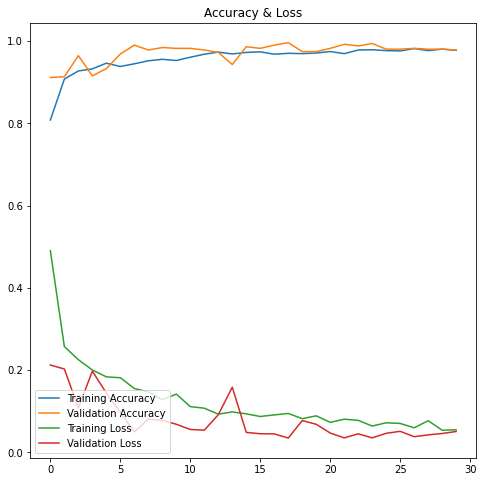

In [ ]:
acc = history_mod.history['acc']
val_acc = history_mod.history['val_acc']

loss = history_mod.history['loss']
val_loss = history_mod.history['val_loss']

epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='lower left')
plt.title('Accuracy & Loss')
plt.show()

#####<b>Step-34:Saving VGG-16 model in json and h5 format</b>

In [ ]:
model_json = model.to_json()
with open("/content/drive/MyDrive/COVID-19 Deep Learning/COVID_19_VGG-16_Classifier.json", "w") as json_file:
    json_file.write(model_json)
model.save('/content/drive/MyDrive/COVID-19 Deep Learning/COVID_19_VGG-16-Classifier.h5')

######<b>Step-35: Testing VGG-16 Model on Test Data</b>

In [ ]:
results = model.evaluate(test_data_gen,batch_size=50)
print("test_loss, test accuracy",results)

11/11 [==============================] - 138s 13s/step - loss: 0.2621 - acc: 0.9173
test_loss, test accuracy [0.2621445059776306, 0.9173228144645691]


##### <b>Step-36: Visualizing Result of VGG-16 Model with Confidence</b>

Model has 1.0 confidence,that image is of NORMAL class.


<Figure size 720x720 with 0 Axes>

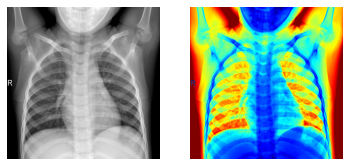

In [ ]:
model = tf.keras.models.load_model('/content/drive/MyDrive/COVID-19 Deep Learning/COVID_19_VGG-16-Classifier.h5')
image_1 = cv2.imread('/content/drive/MyDrive/COVID-19 Deep Learning/Test/NORMAL/NORMAL (1096).png')
heatmap_img = cv2.applyColorMap(image_1, cv2.COLORMAP_JET)
image = cv2.resize(image_1, (224,224))
image = image.astype("float")/255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
predict = model.predict(image)
classes=np.argmax(predict,axis=1)
if classes==0:
  res = "COVID-19"
elif classes==1:
  res = "NORMAL"
elif classes==2:
  res = "VIRAL PNEUMONIA"
confidence = str(round(max(predict[0]), 2))

plt.figure(figsize=(10,10))
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(image_1)
axarr[0].axis("off")
axarr[1].imshow(heatmap_img)
axarr[1].axis("off")
print('Model has {} confidence,that image is of {} class.'.format(confidence,res))

Model has 0.7 confidence,that image is of COVID-19 class.


<Figure size 720x720 with 0 Axes>

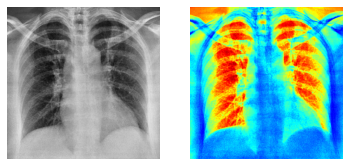

In [ ]:
image_2 = cv2.imread('/content/drive/MyDrive/COVID-19 Deep Learning/Test/COVID-19/COVID-19 (1002).png')
heatmap_img = cv2.applyColorMap(image_2, cv2.COLORMAP_JET)
image = cv2.resize(image_2, (224,224))
image = image.astype("float")/255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)
predict = model.predict(image)
classes=np.argmax(predict,axis=1)
if classes==0:
  res = "COVID-19"
elif classes==1:
  res = "NORMAL"
elif classes==2:
  res = "VIRAL PNEUMONIA"
confidence = str(round(max(predict[0]), 2))
plt.figure(figsize=(10,10))
f, axarr = plt.subplots(1,2) 
axarr[0].imshow(image_2)
axarr[0].axis("off")
axarr[1].imshow(heatmap_img)
axarr[1].axis("off")
print('Model has {} confidence,that image is of {} class.'.format(confidence,res))

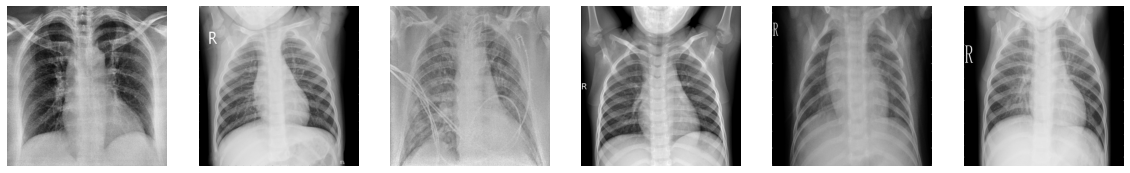

In [ ]:
covid_image = cv2.imread('/content/drive/MyDrive/COVID-19 Deep Learning/Test/COVID-19/COVID-19 (1002).png')
covid_image_1 = cv2.imread('/content/drive/MyDrive/COVID-19 Deep Learning/Test/COVID-19/COVID-19 (1005).png')
normal_image = cv2.imread('/content/drive/MyDrive/COVID-19 Deep Learning/Test/NORMAL/NORMAL (1092).png')
normal_image_2 = cv2.imread('/content/drive/MyDrive/COVID-19 Deep Learning/Test/NORMAL/NORMAL (1096).png')
pn_image = cv2.imread('/content/drive/MyDrive/COVID-19 Deep Learning/Test/Viral Pneumonia/Viral Pneumonia (289).png')
pn_image_2 = cv2.imread('/content/drive/MyDrive/COVID-19 Deep Learning/Test/Viral Pneumonia/Viral Pneumonia (292).png')
fig, axarr = plt.subplots(1, 6, figsize=(20,20))
axarr[0].imshow(covid_image)
axarr[0].axis("off")
axarr[1].imshow(normal_image)
axarr[1].axis("off")
axarr[2].imshow(covid_image_1)
axarr[2].axis("off")
axarr[3].imshow(normal_image_2)
axarr[3].axis("off")
axarr[4].imshow(pn_image)
axarr[4].axis("off")
axarr[5].imshow(pn_image_2)
axarr[5].axis("off")
plt.show()